In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from icevision.all import *

In [3]:
data_url = 'https://s3.amazonaws.com/fast-ai-sample/camvid_tiny.tgz'
data_dir = icedata.load_data(data_url, 'camvid_tiny') / 'camvid_tiny'

In [4]:
codes = np.loadtxt(data_dir/'codes.txt', dtype=str)
class_map = ClassMap(list(codes))

In [5]:
images_dir = data_dir/'images'
labels_dir = data_dir/'labels'

In [9]:
image_files = get_image_files(images_dir)

In [13]:
records = RecordCollection(SemanticSegmentationRecord)

for image_file in pbar(image_files):
    record = records.get_by_record_id(image_file.stem)

    if record.is_new:
        record.set_filepath(image_file)
        record.set_img_size(get_img_size(image_file))
        record.segmentation.set_class_map(class_map)

    mask_file = SemanticMaskFile(labels_dir / f'{image_file.stem}_P.png')
    record.segmentation.set_mask(mask_file)
    
records = records.autofix()
train_records, valid_records = records.make_splits(RandomSplitter([0.8, 0.2]))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
records[:6].show()

In [ ]:
record.show()

In [ ]:
records.show()

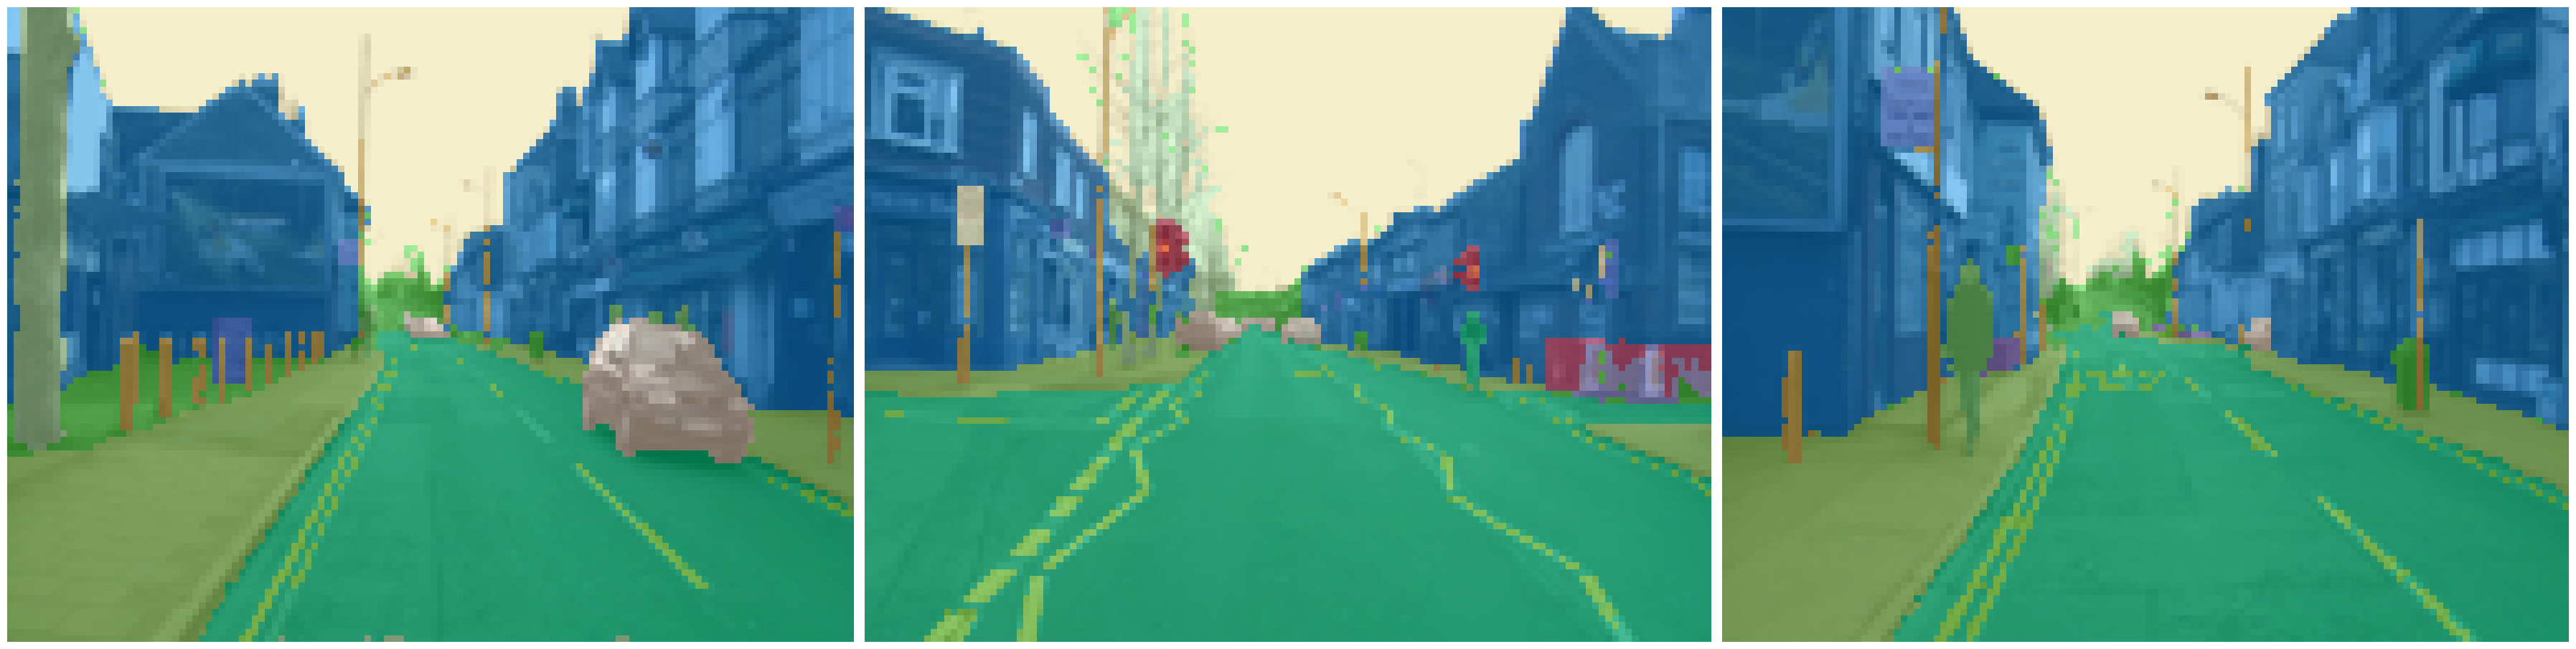

In [17]:
sample_records = random.choices(records, k=3)
show_records(sample_records, ncols=3)

In [19]:
presize, size = 512, 384
presize, size = ImgSize(presize, int(presize*.75)), ImgSize(size, int(size*.75))

aug_tfms = tfms.A.aug_tfms(presize=presize, size=size, pad=None,
                           crop_fn=partial(tfms.A.RandomCrop, p=0.5),
                           shift_scale_rotate=tfms.A.ShiftScaleRotate(rotate_limit=2),
                          )
train_tfms = tfms.A.Adapter([*aug_tfms, tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.resize(size), tfms.A.Normalize()])

In [20]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [26]:
train_ds[0]

BaseRecord

common: 
	- Filepath: /home/lgvaz/.icevision/data/camvid_tiny/camvid_tiny/images/Seq05VD_f00000.png
	- Img: 384x288x3 <np.ndarray> Image
	- Record ID: Seq05VD_f00000
	- Image size ImgSize(width=384, height=288)
segmentation: 
	- Class Map: <ClassMap: {'background': 0, 'Animal': 1, 'Archway': 2, 'Bicyclist': 3, 'Bridge': 4, 'Building': 5, 'Car': 6, 'CartLuggagePram': 7, 'Child': 8, 'Column_Pole': 9, 'Fence': 10, 'LaneMkgsDriv': 11, 'LaneMkgsNonDriv': 12, 'Misc_Text': 13, 'MotorcycleScooter': 14, 'OtherMoving': 15, 'ParkingBlock': 16, 'Pedestrian': 17, 'Road': 18, 'RoadShoulder': 19, 'Sidewalk': 20, 'SignSymbol': 21, 'Sky': 22, 'SUVPickupTruck': 23, 'TrafficCone': 24, 'TrafficLight': 25, 'Train': 26, 'Tree': 27, 'Truck_Bus': 28, 'Tunnel': 29, 'VegetationMisc': 30, 'Void': 31, 'Wall': 32}>
	- masks: [<icevision.core.mask.SemanticMaskFile object at 0x7f4e75987110>]
	- mask_array: <icevision.core.mask.MaskArray object at 0x7f4e7596b410>

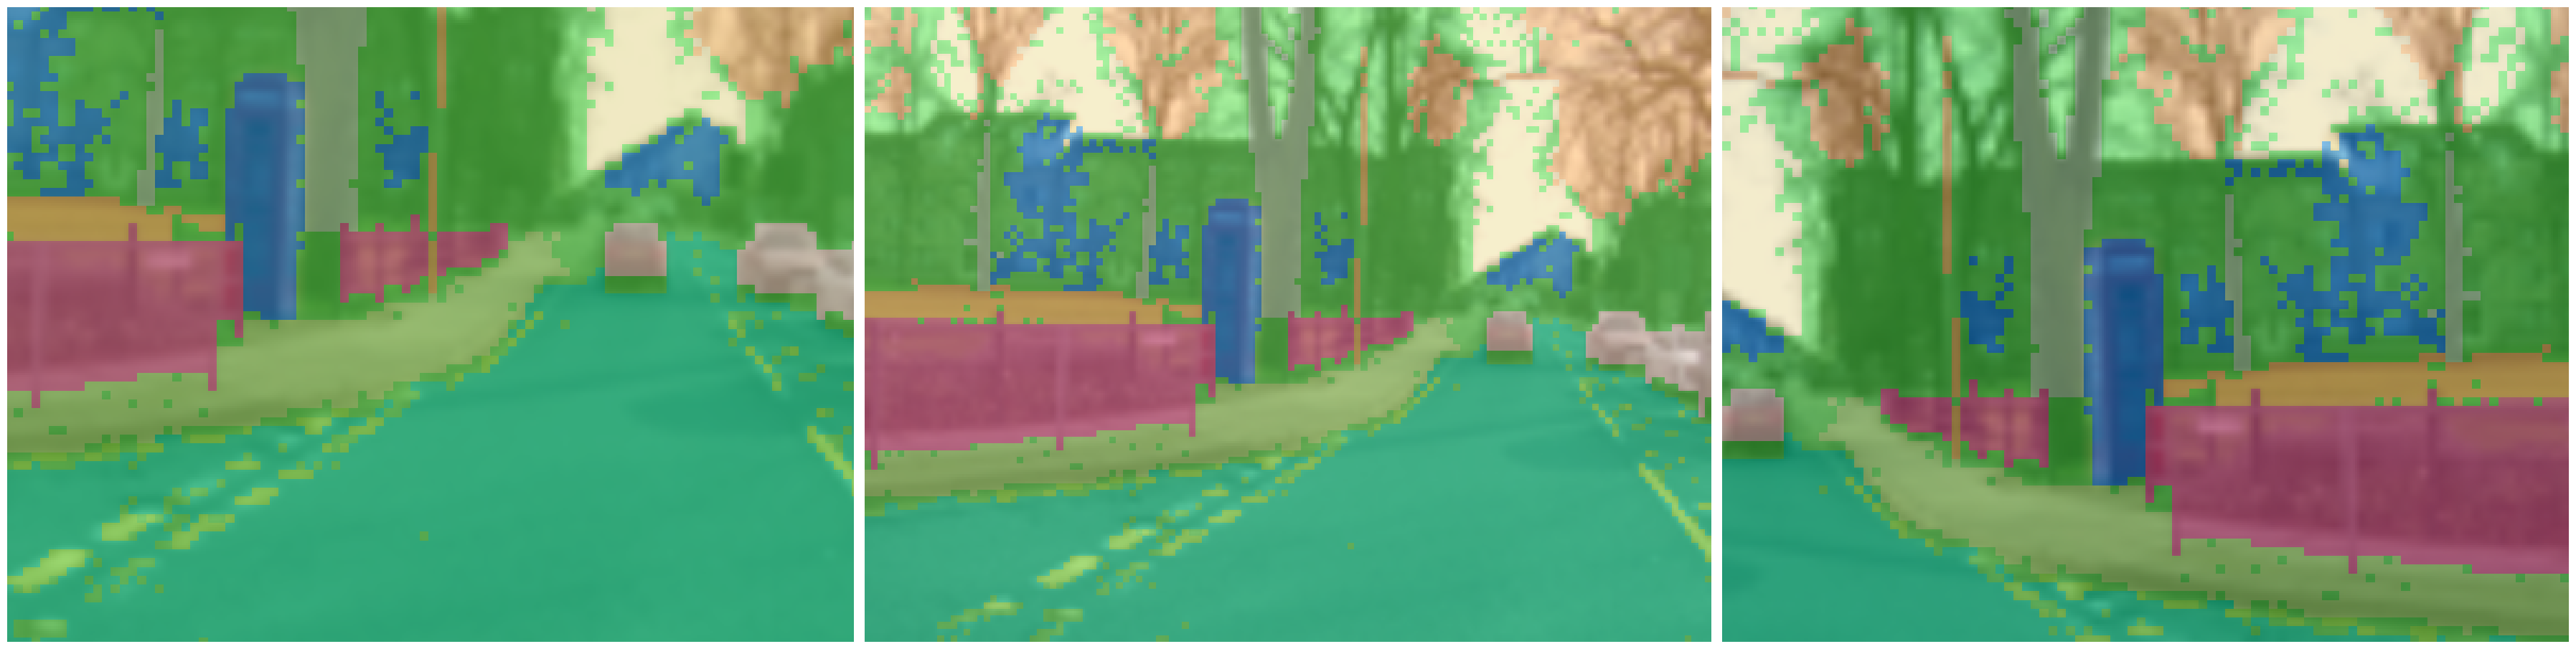

In [21]:
ds_samples = [train_ds[0] for _ in range(3)]
show_samples(ds_samples, ncols=3)

## COCO

[
{image_id: 2, segmentation: Polygon(23, 45, 12, 67),
{image_id: 2, segmentation: Polygon(12, 876, 345, 765),
]

Instance segmentation: (20, 512, 512); labels = [bike, car, bike, person, ...]
Semantic segmentation: (512, 512)

In [24]:
model_type = models.fastai.unet

In [25]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [15]:
backbone = model_type.backbones.resnet34()
model = model_type.model(backbone=backbone, num_classes=class_map.num_classes, img_size=size)

In [16]:
def accuracy_camvid(pred, target):
    # ignores void pixels
    keep_idxs = target != class_map.get_by_name('Void')
    target = target[keep_idxs]
    pred = pred.argmax(dim=1)[keep_idxs]

    return (pred==target).float().mean() 

In [17]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=[accuracy_camvid])

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.0002290867705596611)

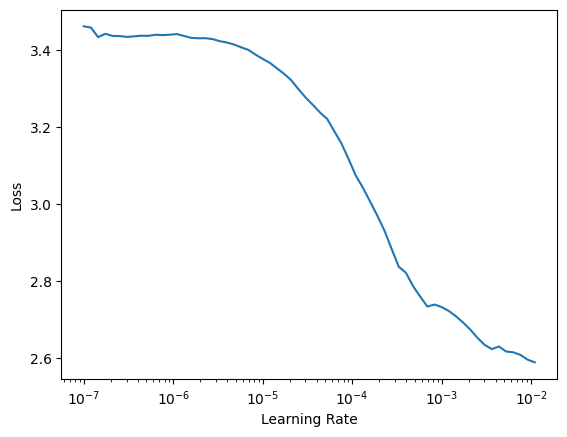

In [18]:
learn.lr_find()

In [19]:
learn.fine_tune(3, 1e-4)

epoch,train_loss,valid_loss,accuracy_camvid,time
0,3.065141,2.367923,0.481144,00:09


epoch,train_loss,valid_loss,accuracy_camvid,time
0,2.146140,1.841009,0.604703,00:08
1,1.887944,1.443686,0.646265,00:08
2,1.698547,1.363914,0.666019,00:08


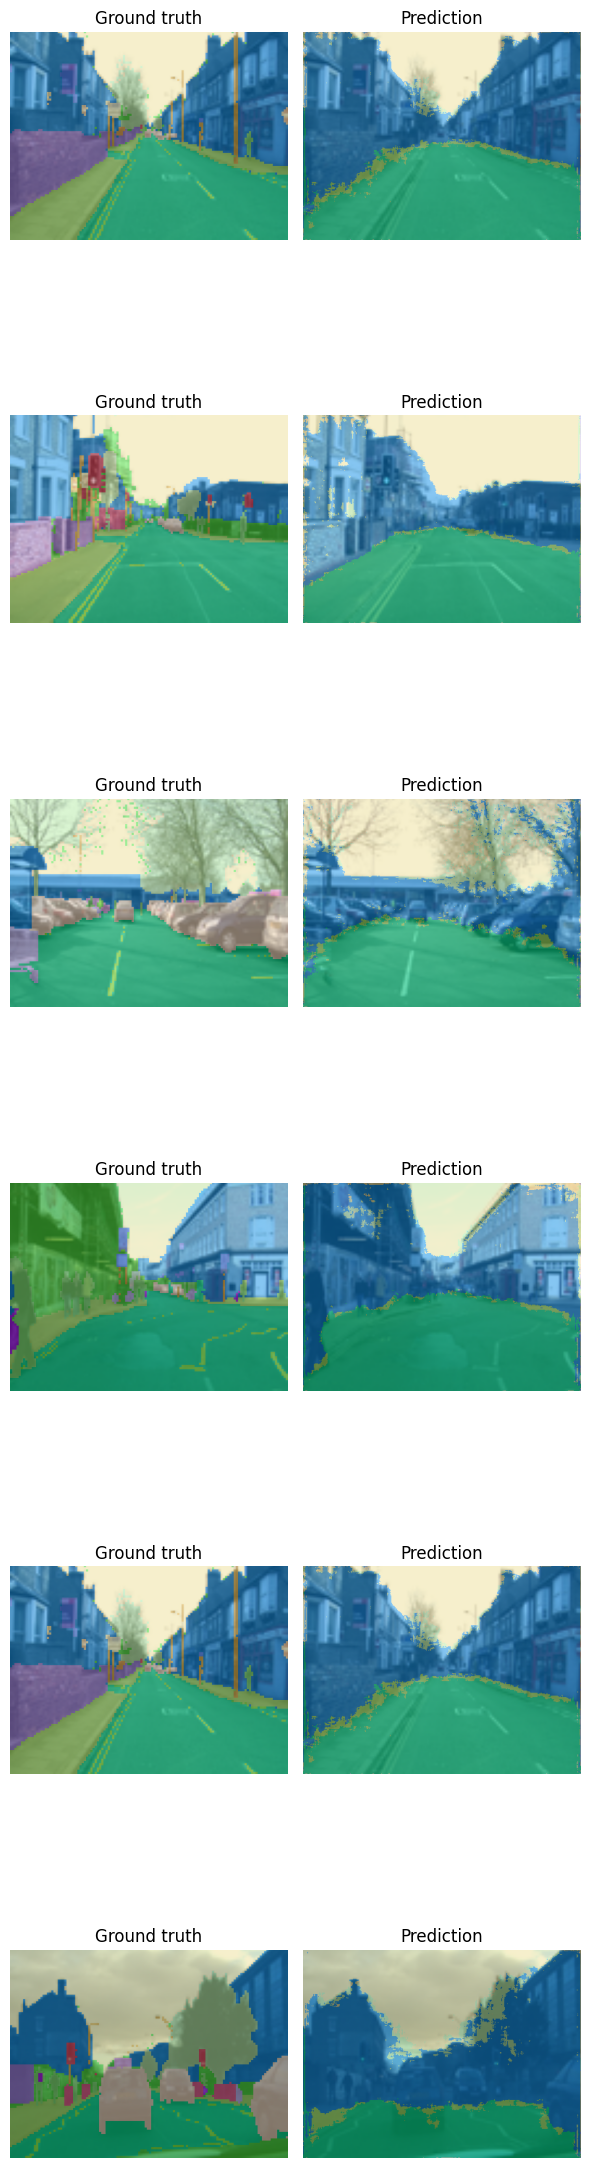

In [20]:
model_type.show_results(model, valid_ds)

In [21]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'data'

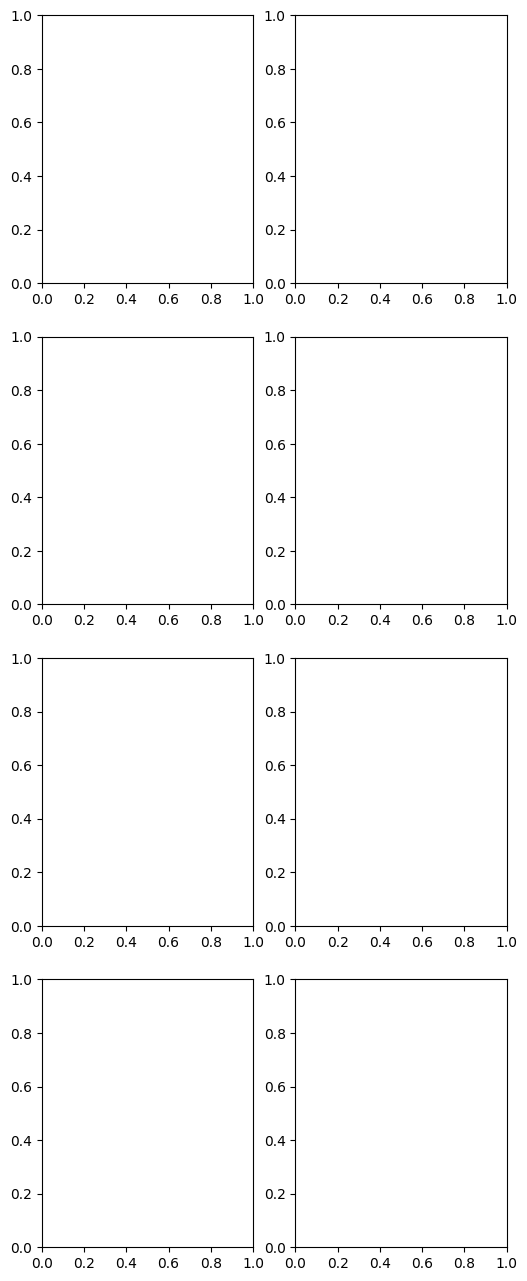

In [22]:
show_preds(preds=preds[:4], ncols=3)